# Project 3 - Promoter Regions

In [1]:
# Les imports nécessaires dans le cadre de ce mini-projet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import utils
import project

## 2 Préliminaires : données et lecture des fichiers

In [2]:
cerevisae, chromos_flattened, counts, freqs = \
    utils.read_file("sequences/yeast_s_cerevisae_genomic_chr1-4.fna")
print("S. cerevisae contient", len(cerevisae), "chromosones et", \
      len(chromos_flattened), "nucléotides")
print("Voici les nombres d'occurrence et les fréquences d'apparition de chaque nucléotide :")
pd.DataFrame({'Occurrences': counts, 'Fréquence': freqs}, index=utils.nucleotide.keys())

S. cerevisae contient 4 chromosones et 2515853 nucléotides
Voici les nombres d'occurrence et les fréquences d'apparition de chaque nucléotide :


,Occurrences,Fréquence
A,754342,0.299835
C,505943,0.201102
G,503163,0.199997
T,752405,0.299066


## 3.1 Description empirique

Q2) D'après l'hypothèse d'indépendance des occurrences des lettres dans le génome, pour un mot $w = w_1.w_2\dots w_k$ de longueur $k$ donné, on connaît les fréquences des lettres $w_i$ le composant.
Donc, la probabilité de trouver ce mot est donnée par 
$$P(w) = \prod_{i=1}^{k} P(w_i).$$

On peut alors calculer le nombre d'occurrences du mot $w$ dans une séquence de longueur $l$ :
$$\text{comptage_attendu} = (l - k + 1)\cdot P(w),$$
où $l-k+1$ est le nombre de positions des occurrences du mot $w$.



Q3) On remarque dans les histogrammes ci-dessous la présence de mots qui détiennent une fonction spéciale, étant donné que l'écart de entre le comptage observé et le comptage attendu augmente avec la taille des n-grammes, notamment pour les longueur 6 et 8.

Ceci correspond bien à l'hypothèse sur la taille des région promoteurs, qui comptent souvent entre 6 et 10 nucléobases.

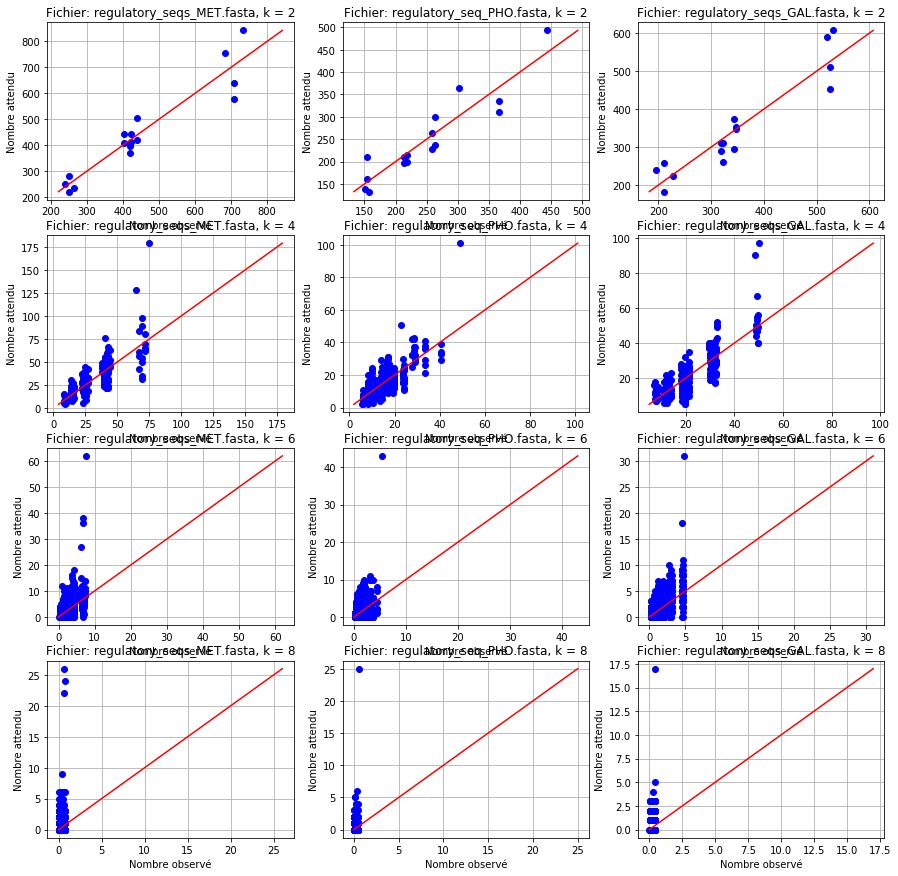

In [11]:
files = ["sequences/regulatory_seqs_MET.fasta", "sequences/regulatory_seq_PHO.fasta", \
         "sequences/regulatory_seqs_GAL.fasta"]
chromos_list = [] # la séquence de nucléotides des 3 séquences de régulation
ks = [2, 4, 6, 8]
fig, axes = plt.subplots(len(ks), len(files), figsize=(15, 15))
for i in range(len(files)):
    _, chromos, _, freqs = utils.read_file(files[i])
    chromos_list += chromos
    for ind_k, k in enumerate(ks):
        obs = project.k_grams_occurrences(chromos, k)
        exp = project.comptage_attendu(k, len(chromos), freqs)
        observed, expected = utils.encode_file(chromos, k, freqs, obs, exp)
        utils.plot(xs=observed, ys=expected, xlabel="Nombre observé", \
                   ylabel="Nombre attendu", \
                   title="Fichier: " + files[i][10:] + ", k = " + str(k), \
                   ax=axes[ind_k, i])
        
# la distribution de probabilité des nucléotides sur la concaténation des 3 fichiers
probas = utils.nucleotide_frequency(chromos_list) 

## 3.2 Simulation de séquences aléatoires

Q3) On estime la probabilité d'observer un mot un certain nombre $n$ de fois par le proportion de séquences simulées où le mot est apparu au moins $n$ fois, c'est-à-dire
$$P(N \geq n) \approx P_{emp}(N \geq n) = \frac{1}{S}\cdot \sum_{i=1}^{S} \unicode{x1D7D9}_{N \geq n},$$
où $S$ est le nombre de simulations effectuées.

Q4) Vous trouverez dans la cellule ci-dessous les histogrammes des distributions du comptage d'occurrences pour les mots **ATCTGC**, **ATATAT**, **TTTAAA** et **AAAAAA**.

On remarque que les mots ATATAT et TTTAAA ont la même probabilité d'apparaître, puisque la probabilité empirique d'un nombre d'occurrences nul est zéro.
Cependant, leurs distributions de comptage d'occurrences est différente.
En effet, la distribution du mot ATATAT est à peu près uniforme entre 9 et 20, à l'exception des trois pics en 13, 15 et 17.
Quant au mot TTTAAA, il y a un pic en 14 et elle decroît au fur et à mesure qu'on s'éloigne de cette valeur. 

Convergence after 3 iterations


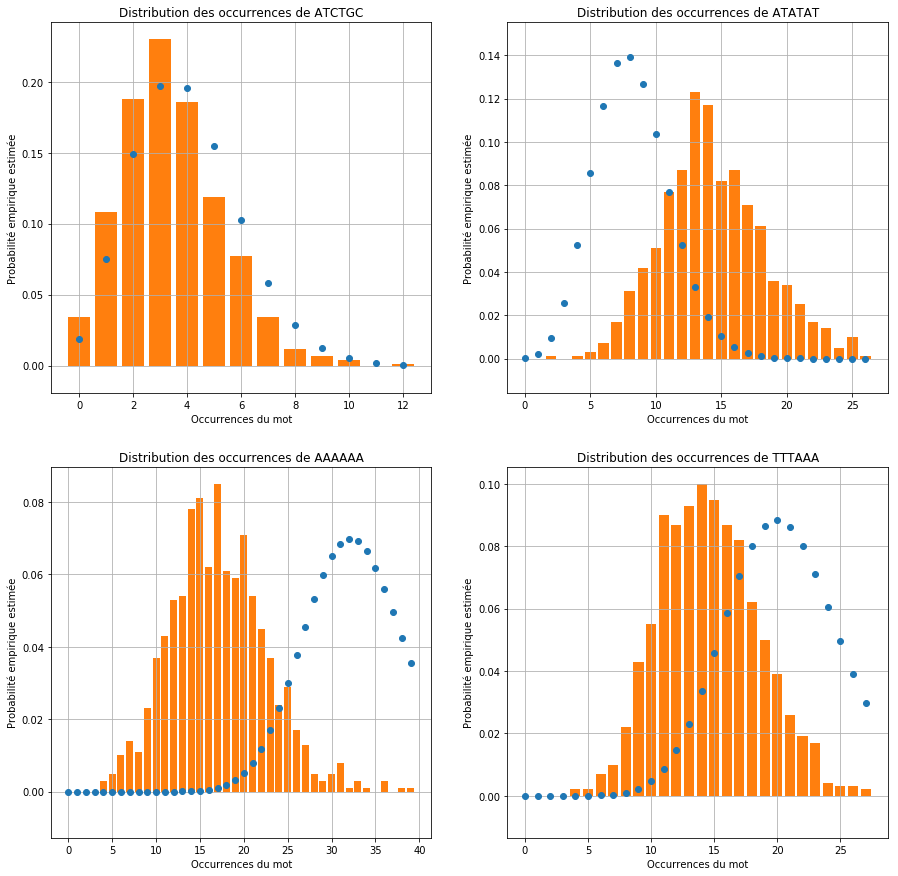

In [8]:
project.plot_histogram(chromos_list,probas, 1000)

Q5) On peut calculer un intervalle de confiance pour la probabilité d'observer un mot avec sa probabilité empirique : 
$$p_{emp} \sim \mathcal{N}\left(p, \sqrt \frac{p\cdot (1-p)}{n}\right),$$
où $n$ est le nombre de simulations effectuées.

Pour un risque de 5 % ($z_{2.5\%} = 1.96$), on obtient l'intervalle
$$\left[p_{emp} - 1.96 \cdot \sqrt \frac{p_{emp}\cdot (1-p_{emp})}{n}, 
p_{emp} - 1.96 \cdot \sqrt \frac{p_{emp}\cdot (1-p_{emp})}{n} \right]$$

## 3.3 Modèles de dinucléotides et trinucléotides

Q1) On prend $\mathcal{X} = \{A, C, G, T\}$. Le modèle décrit correspond à une chaîne de Markov homogène d'ordre 1 car il remplit les 3 conditions :
- c'est une processus stochastique à temps discret avec les v.a. $X_i$ correpondant à la nucléobase à la position $i$ dans un génome ;
- l'ensemble des états $\mathcal{X}$ est fini ;
- la propriété de markov d'ordre 1 est vérifiée : $\forall i \geq 0, P(X_{i+1}|X_0,\dots, X_i) = P(X_{i+1}|X_i)$.

De plus, cette chaîne de Markov est homogène car les probabilités de transition ne dépendent pas d'une variable temporelle.

Par ailleurs, la probabilité stationnaire de cette chaîne correspond aux proportions des nucléobases auxquelles on s'attend.

Q5) De la même manière que dans la question 3.1.2), le nombre d'occurrences attendu est
$$\text{comptage_attendu} = (l - k + 1)\cdot P(w),$$
sauf que, dans ce cas, la probabilité d'apparition du mot est calculée différemment. En effet, on utilise la propriété de Markov d'ordre 1 pour obtenir le résultat suivant :
$$
\begin{align}
    P(w) &= P(w_1)\cdot \prod_{i=2}^{k} P(w_i|w_1, \dots, w_{i-1}) \\
    P(w) &= P(w_1)\cdot \prod_{i=2}^{k} P(w_i|w_{i-1}).
\end{align}
$$

Pour la probabilité du premier nucléotide, à savoir $P(w_1)$, on a utilisé $\pi^\ast$, i.e. la distribution stationnaire de la chaîne de Markov, pour le calcul de la probabilité ci-dessus.
On a néanmoins remarqué lors du calcul de cette distribution que les $\pi^{(n)}$ convergent très rapidement.
C'est pourquoi on aurait pu utiliser tout simplement $\pi^{(0)}$.

Q6)

In [ ]:
comptage = project.comptage_attendu()
utils.plot(xs=)

## 3.4 Probabilité de mots

Q1) En faisant l'hypothèse d'indépendance des positions d'occurrences d'un mot **non chevauchant** $w$, on peut compter son nombre d'occurrences dans une séquence de longueur $l$ avec la loi $Bin(P(w),\ l-k+1)$, où $P(w)$ sera calculée au moyen des modèles de nucléotides et de dinucléotides.

Q2) Etant donné que la longueur des séquences est au moins de l'ordre de 10 000, le deuxième paramètre de ladite loi binomiale est beaucoup plus grand que la probabilité $P(w)$.

De ce fait, on peut approcher cette loi avec la loi $Pois(P(w)\cdot (l-k+1))$.

### TODO
Q3)

Q5)

# STOP

In [37]:
cerevisae, chromos_flattened, freqs, probas = utils.read_file("sequences/yeast_s_cerevisae_genomic_chr1-4.fna")
obs, exp = project.compare_simulations(len(chromos_flattened),probas,[8],1000)
observed, expected = utils.encode_file(chromos_flattened,j,probas,obs, exp)

SyntaxError: unexpected EOF while parsing (<ipython-input-37-ec9addbe3395>, line 3)

In [70]:
stat_distro = project.stationary_distribution(probas, tmatrix, 0.0000001)

Convergence after 2 iterations


In [20]:
cerevisae,chromos_flattened,freqs,probas = utils.read_file(files[0])

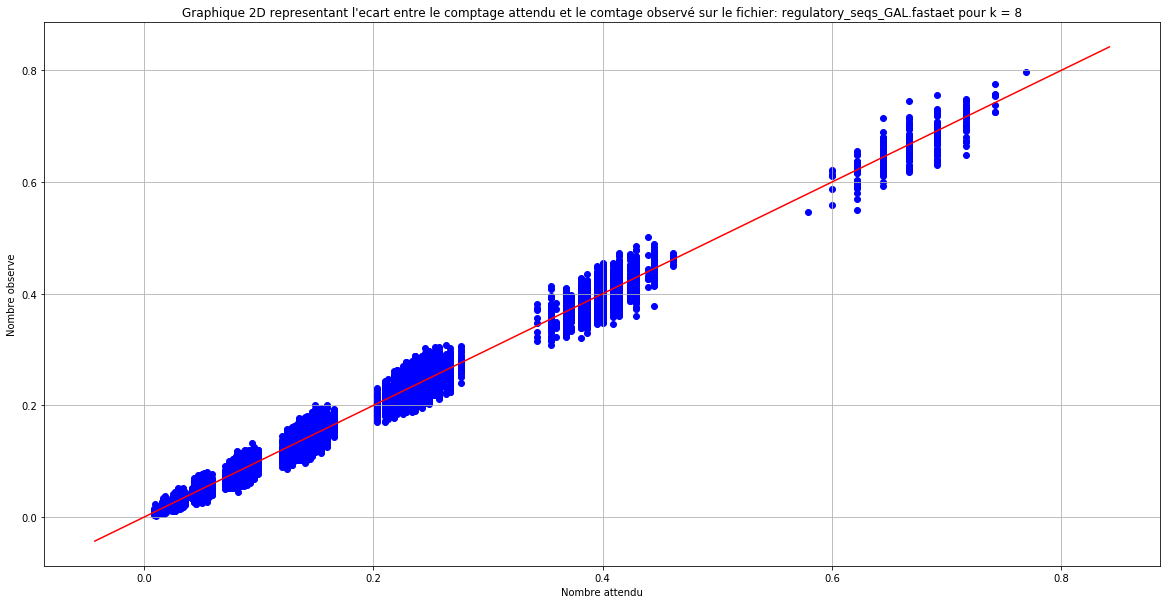

In [25]:
cerevisae,chromos_flattened,freqs,probas = utils.read_file(files[0])
obs, exp = project.compare_simulations(len(chromos_flattened),probas,[8],1000)
observed, expected = utils.encode_file(chromos_flattened,j,probas,obs, exp)
utils.plot(files[i],8,observed,expected)

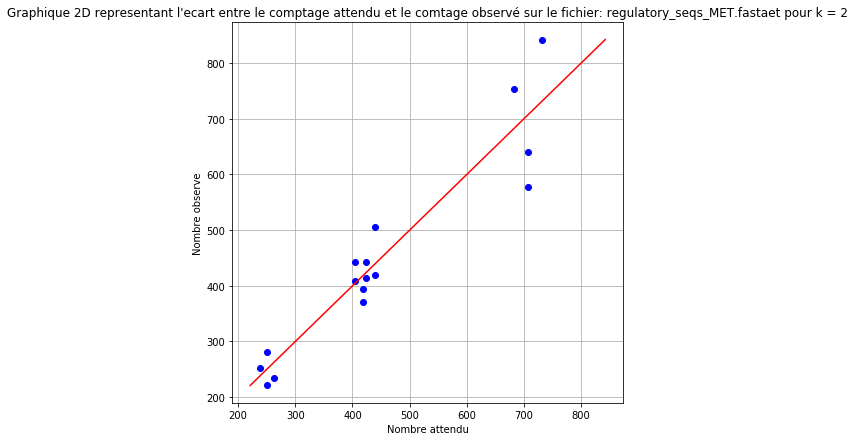

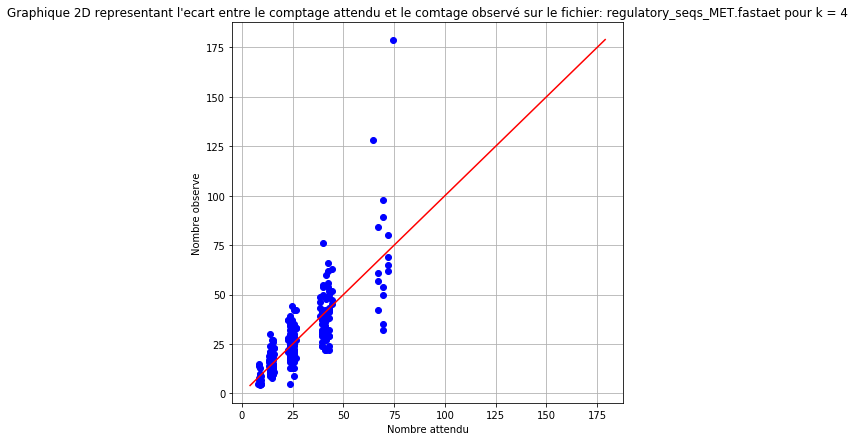

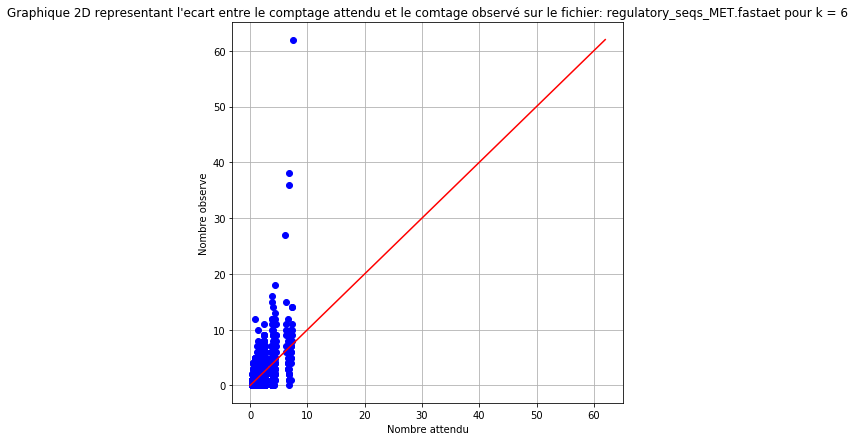

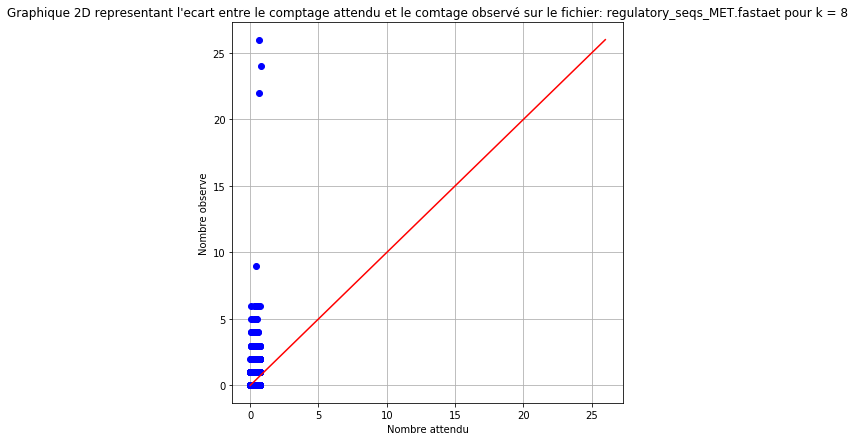

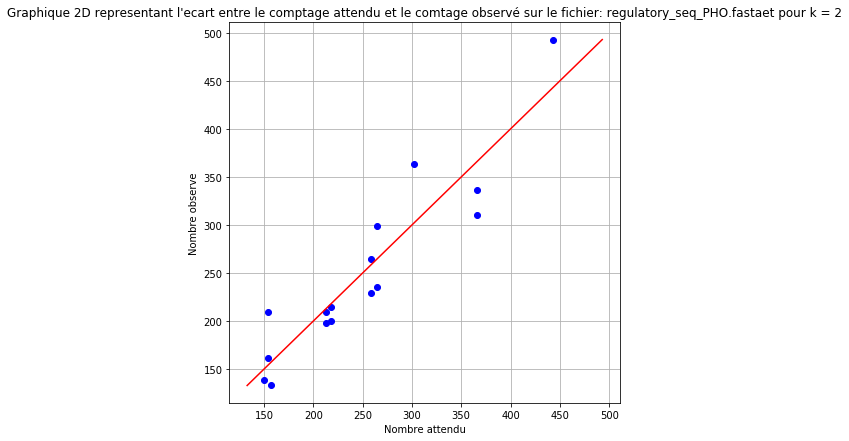

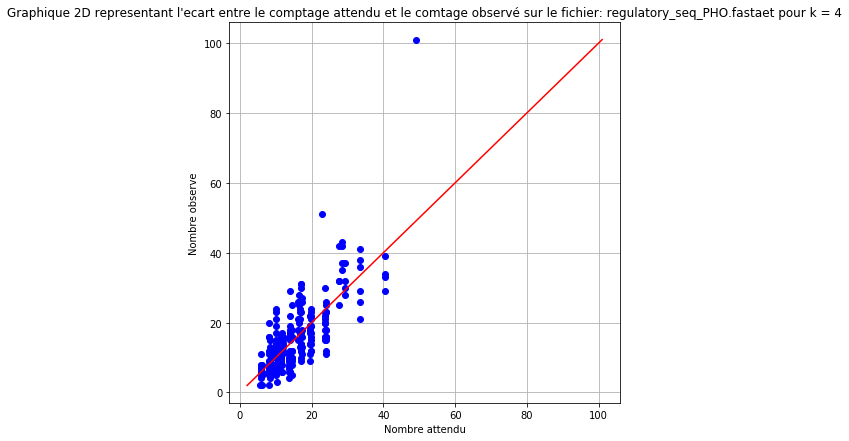

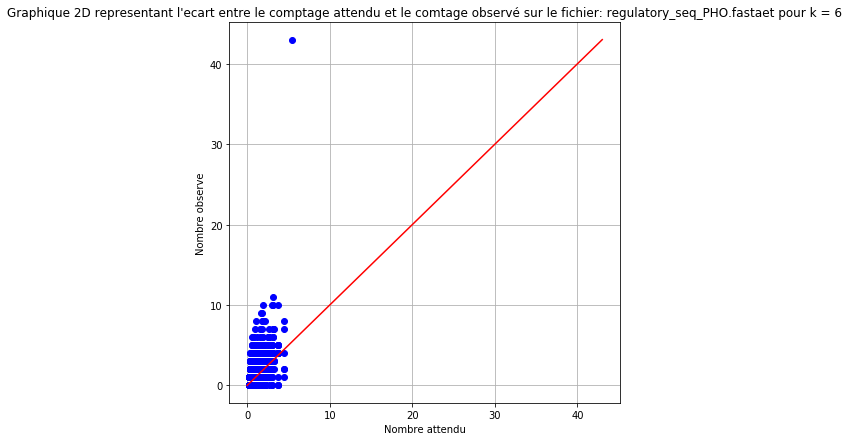

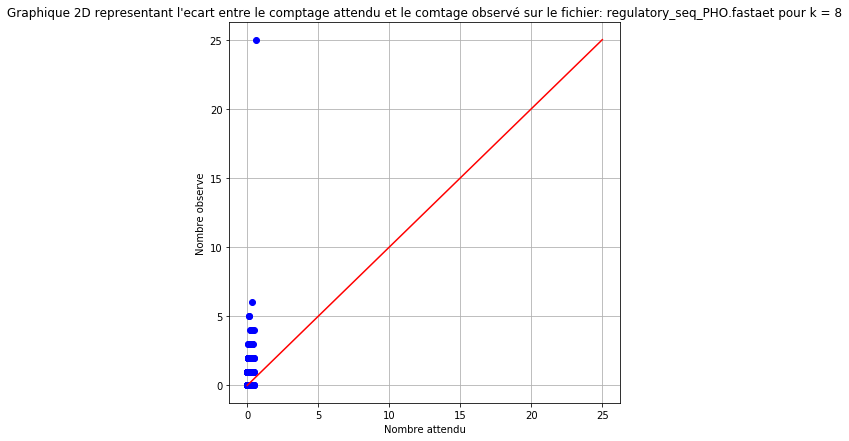

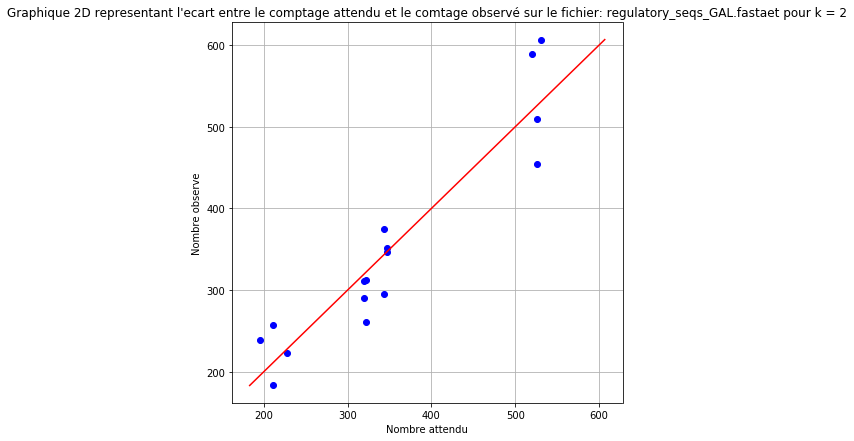

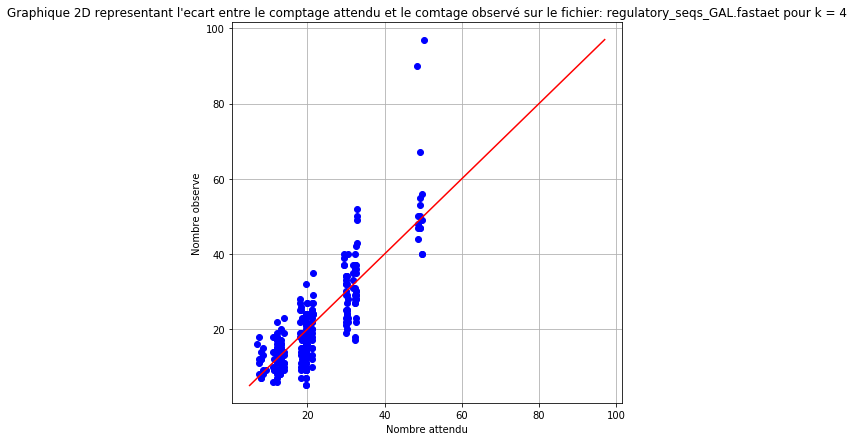

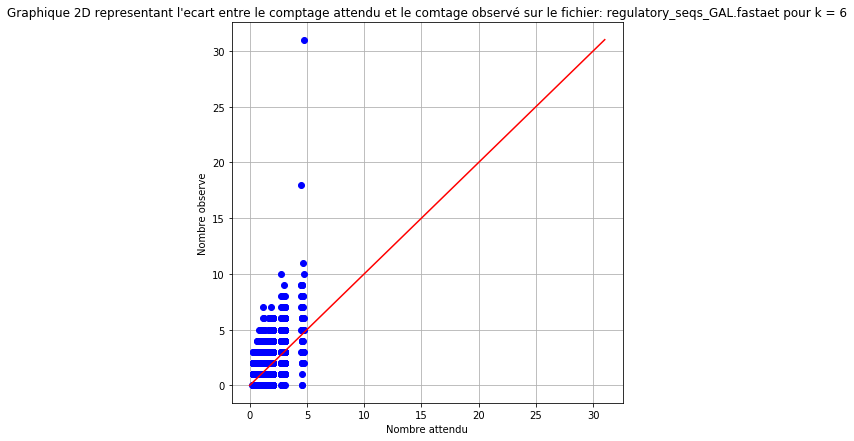

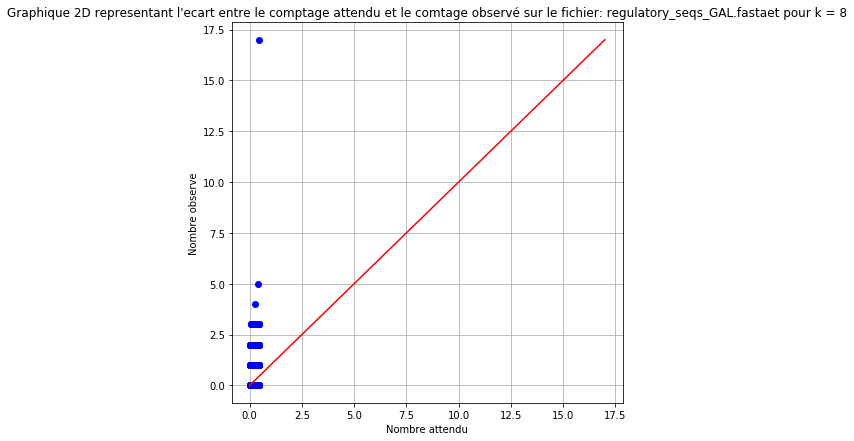

In [37]:
for i in range(len(files)):
    cerevisae,chromos_flattened,freqs,probas = utils.read_file(files[i])
    for j in [2,4,6,8]:
        obs = project.k_grams_occurrences(chromos_flattened,j)
        exp = project.comptage_attendu(j,len(chromos_flattened),probas)
        observed, expected = utils.encode_file(chromos_flattened,j,probas,obs, exp)
        utils.plot(files[i],j,observed,expected)